# Projet FixMatch


## I. Importing libraries and setup

First, we import the libraries we will use in the notebook:

In [1]:
# !pip install torchview torchsummary torchvision kornia torchmetrics matplotlib tqdm path graphviz opencv-python scikit-learn optuna

In [2]:
# system
import sys
sys.path.append('..')

# data
import numpy as np

# deep learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# torchvision
import torchvision

# plotting
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# utils and model
from utils.utils import (
    seedEverything,
    compute_mean_std,
    data_transform,
    normalize,
    plot_images,
)

from utils.model import ConvNN

# SUPERVISED
from supervised import supervised_train

# os
import os
import path

# sklearn - confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


%load_ext autoreload
%autoreload 2

In [3]:
# Set device
if ((int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13)) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


We initialize global variables, according to the values in the paper, used in the fixmatch algorithm:

In [4]:
IMG_SHAPE = (3, 32, 32)
BATCH_SIZE = 64
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.0005

In [5]:
# Download both datasets
trainset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=data_transform())
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=data_transform())

# convert to data loaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# compute mean and std
if not os.path.exists('../data/mean.pt'):
    mean, std = compute_mean_std(trainloader)
    torch.save(mean, '../data/mean.pt')
    torch.save(std, '../data/std.pt')
else:
    mean, std = torch.load('../data/mean.pt'), torch.load('../data/std.pt')

# to numpy
mean, std = mean.numpy(), std.numpy()

print(f"mean: {mean}, std: {std}")

mean: [0.49135667 0.48212072 0.4465159 ], std: [0.24632095 0.24274482 0.26062676]


In [7]:
# define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [8]:
torch_models = './results/models/' 
if not os.path.exists(torch_models):
    os.makedirs(torch_models)

## II. Convolutional Neural Network - Full Supervised

### II.1. CNN on 100% dataset

In [9]:
seedEverything()

SUBSET_PROP = 1.00

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [10]:
EPOCHS = 29

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample))))) * 100/3
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [11]:
supervised_train(
    model=model,
    trainloader=trainloader_subsample,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    mean=mean,
    std=std,
    epochs=EPOCHS,
    name='100'
)

Start training


Epoch     0:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 62.79%


Epoch     1:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 73.42%


Epoch     2:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 72.06%


Epoch     3:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 69.74%


Epoch     4:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 70.29%


Epoch     5:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 76.7%


Epoch     6:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 79.63%


Epoch     7:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 75.43%


Epoch     8:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 71.72%


Epoch     9:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 74.34%


Epoch    10:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 79.56%


Epoch    11:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 79.75%


Epoch    12:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 74.48%


Epoch    13:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 74.52%


Epoch    14:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 78.1%


Epoch    15:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.05%


Epoch    16:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 78.2%


Epoch    17:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 73.58%


Epoch    18:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 74.3%


Epoch    19:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 79.59%


Epoch    20:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.42%


Epoch    21:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 75.57%


Epoch    22:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 72.3%


Epoch    23:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 77.33%


Epoch    24:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 80.27%


Epoch    25:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 79.87%


Epoch    26:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 73.46%


Epoch    27:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 75.36%


Epoch    28:   0%|          | 0/782 [00:00<?, ?batch/s]

Test Accuracy: 79.58%
Finished Training


In [12]:
# open results
model_100 = ConvNN().to(device)
model_100.load_state_dict(torch.load('./results/models/model_100.pth'))
train_losses_100 = torch.load('./results/metrics/train_losses_100.pth')
train_accuracies_100 = torch.load('./results/metrics/train_accuracies_100.pth')
test_losses_100 = torch.load('./results/metrics/test_losses_100.pth')
test_accuracies_100 = torch.load('./results/metrics/test_accuracies_100.pth')

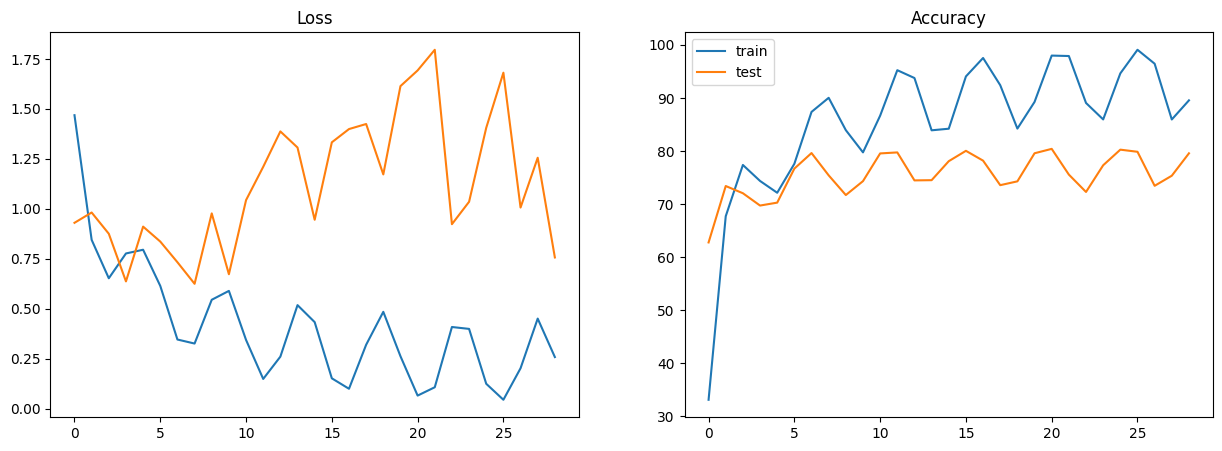

In [13]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_100, label="train")
ax1.plot(test_losses_100, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_100, label="train")
ax2.plot(test_accuracies_100, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_100.png")

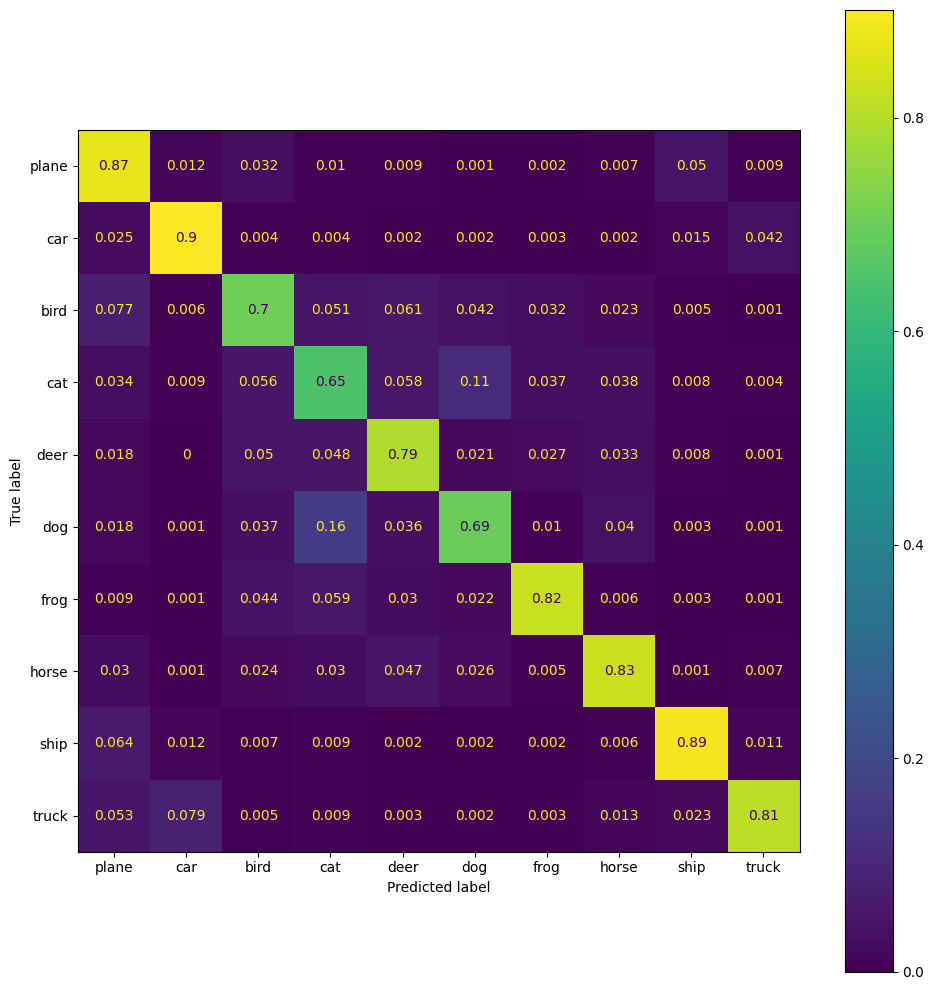

In [14]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_100(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_100.png")

Test Accuracy: 79.58%


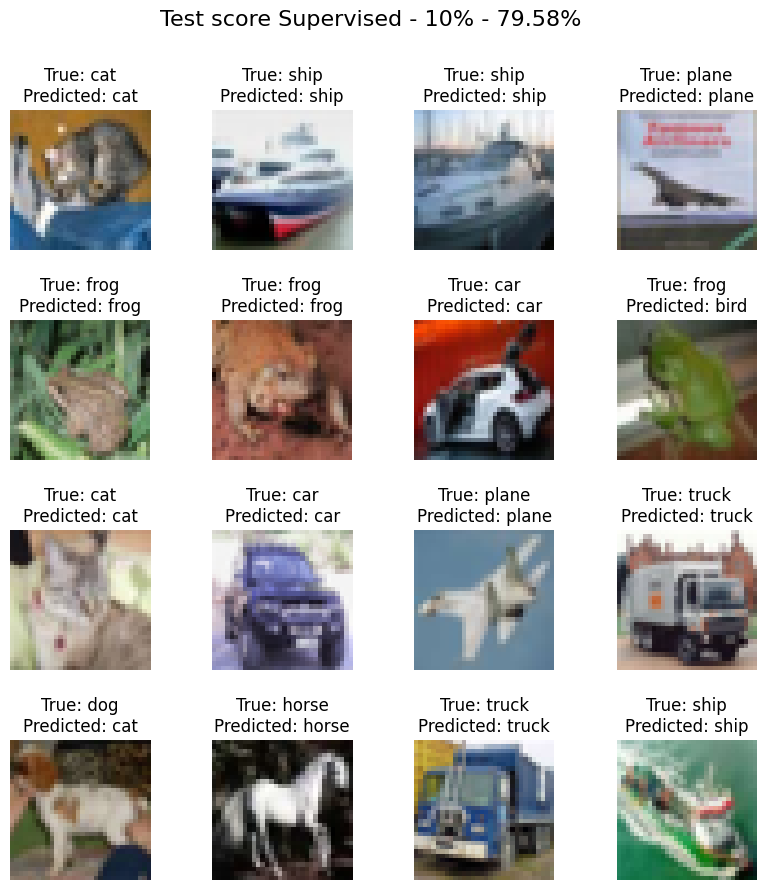

In [19]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_100(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score Supervised - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_100.png")

### II.2 CNN on 10% dataset

In [53]:
seedEverything()

SUBSET_PROP = 0.10

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [54]:
EPOCHS = 50

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample))))) * 100/3
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [55]:
supervised_train(
    model=model,
    trainloader=trainloader_subsample,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    mean=mean,
    std=std,
    epochs=EPOCHS,
    name='10'
)

Start training


Epoch     0:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 29.42%


Epoch     1:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 36.79%


Epoch     2:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 36.17%


Epoch     3:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 27.56%


Epoch     4:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 39.98%


Epoch     5:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.54%


Epoch     6:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.79%


Epoch     7:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 42.06%


Epoch     8:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 26.91%


Epoch     9:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 45.64%


Epoch    10:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.99%


Epoch    11:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.13%


Epoch    12:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 41.15%


Epoch    13:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 50.5%


Epoch    14:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.89%


Epoch    15:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 60.09%


Epoch    16:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 55.86%


Epoch    17:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.1%


Epoch    18:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.4%


Epoch    19:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.44%


Epoch    20:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.57%


Epoch    21:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.81%


Epoch    22:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 49.76%


Epoch    23:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.06%


Epoch    24:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.41%


Epoch    25:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.21%


Epoch    26:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.85%


Epoch    27:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 47.38%


Epoch    28:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 56.07%


Epoch    29:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.02%


Epoch    30:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.59%


Epoch    31:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 53.97%


Epoch    32:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 54.45%


Epoch    33:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.45%


Epoch    34:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.43%


Epoch    35:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.25%


Epoch    36:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 52.83%


Epoch    37:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 57.64%


Epoch    38:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 58.87%


Epoch    39:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.22%


Epoch    40:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.15%


Epoch    41:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.34%


Epoch    42:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.43%


Epoch    43:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.43%


Epoch    44:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.45%


Epoch    45:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.44%


Epoch    46:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.49%


Epoch    47:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.49%


Epoch    48:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.45%


Epoch    49:   0%|          | 0/79 [00:00<?, ?batch/s]

Test Accuracy: 59.36%
Finished Training


In [56]:
# open results
model_10 = ConvNN().to(device)
model_10.load_state_dict(torch.load('./results/models/model_10.pth'))
train_losses_10 = torch.load('./results/metrics/train_losses_10.pth')
train_accuracies_10 = torch.load('./results/metrics/train_accuracies_10.pth')
test_losses_10 = torch.load('./results/metrics/test_losses_10.pth')
test_accuracies_10 = torch.load('./results/metrics/test_accuracies_10.pth')

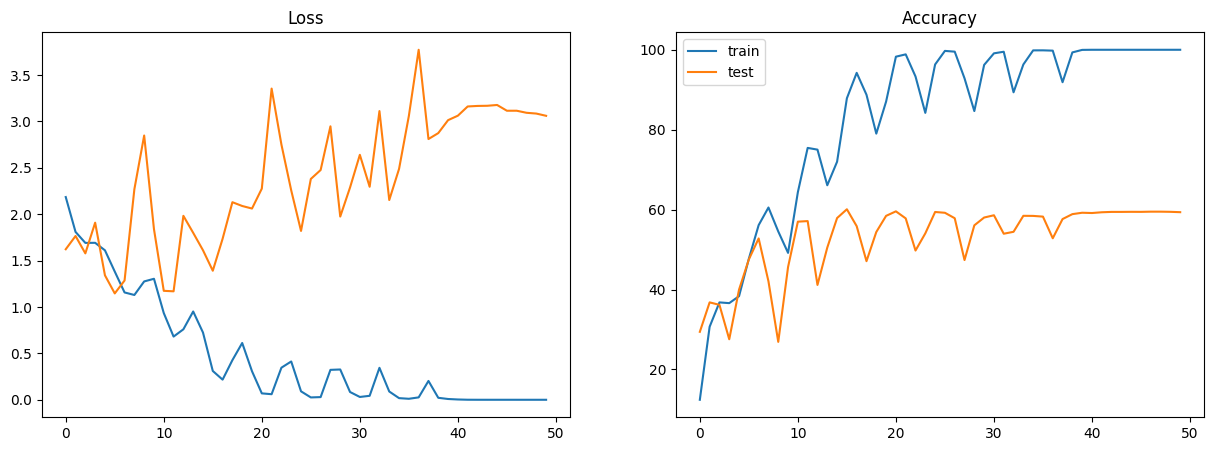

In [57]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_10, label="train")
ax1.plot(test_losses_10, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_10, label="train")
ax2.plot(test_accuracies_10, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_10.png")

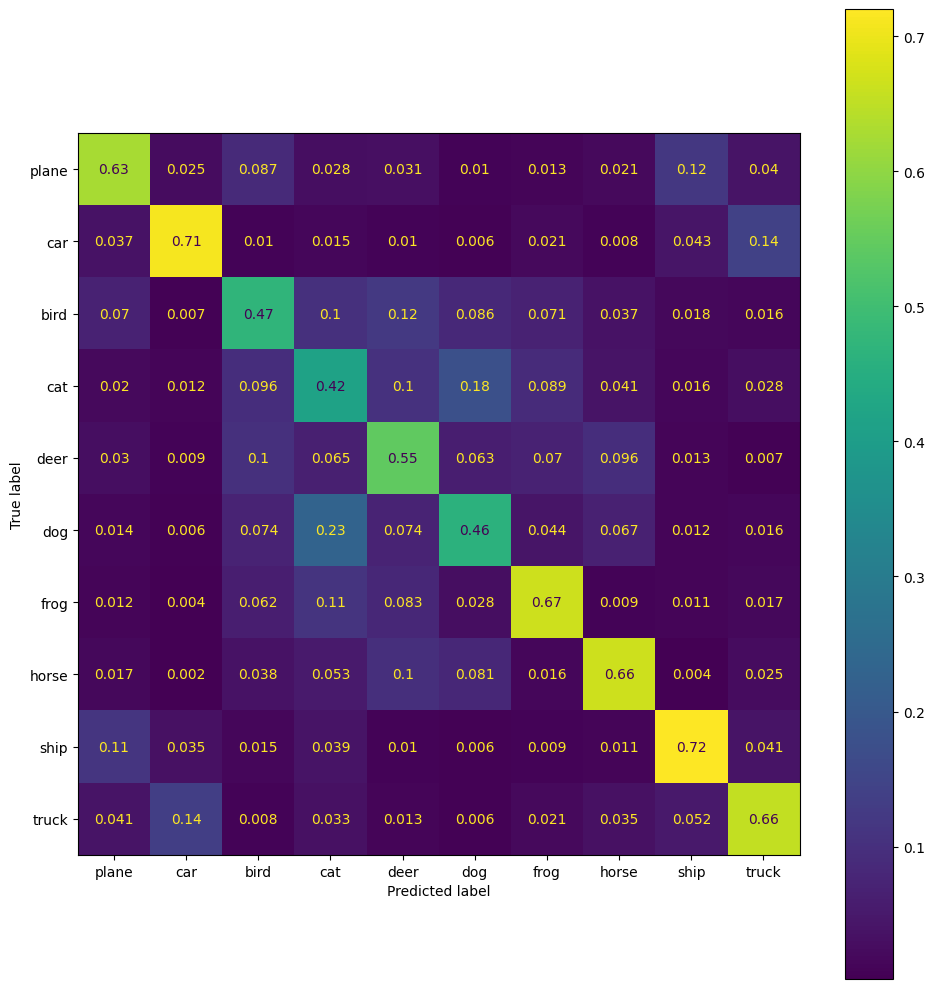

In [58]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_10(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_10.png")

Test Accuracy: 59.36%


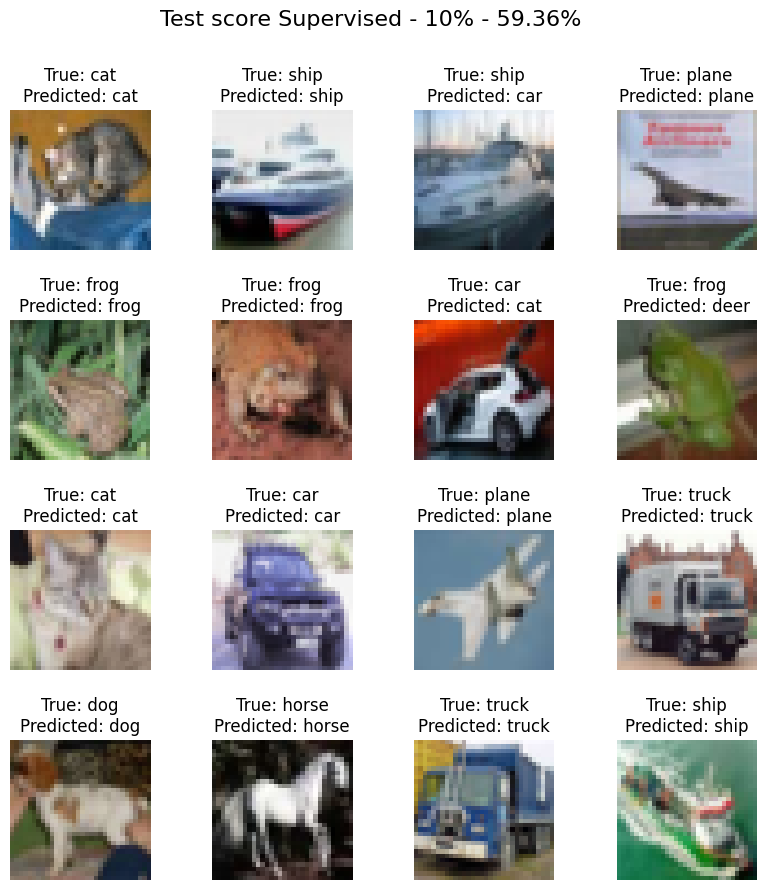

In [59]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_10(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score Supervised - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_10.png")

### II.3 CNN on 5% dataset

In [46]:
seedEverything()

SUBSET_PROP = 0.05

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [47]:
EPOCHS = 50

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample))))) * 100/3
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [48]:
supervised_train(
    model=model,
    trainloader=trainloader_subsample,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    mean=mean,
    std=std,
    epochs=EPOCHS,
    name='05'
)

Start training


Epoch     0:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 19.37%


Epoch     1:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 25.95%


Epoch     2:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 24.05%


Epoch     3:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 25.09%


Epoch     4:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 19.47%


Epoch     5:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 34.33%


Epoch     6:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 38.37%


Epoch     7:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 24.48%


Epoch     8:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 20.38%


Epoch     9:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 39.69%


Epoch    10:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.76%


Epoch    11:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.76%


Epoch    12:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 40.86%


Epoch    13:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 21.28%


Epoch    14:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 41.13%


Epoch    15:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.27%


Epoch    16:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 45.66%


Epoch    17:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 34.64%


Epoch    18:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 21.0%


Epoch    19:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.08%


Epoch    20:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 51.16%


Epoch    21:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.28%


Epoch    22:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 25.35%


Epoch    23:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 38.98%


Epoch    24:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.21%


Epoch    25:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 44.61%


Epoch    26:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 36.82%


Epoch    27:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 33.36%


Epoch    28:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.11%


Epoch    29:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.61%


Epoch    30:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.31%


Epoch    31:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 23.64%


Epoch    32:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 35.06%


Epoch    33:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.91%


Epoch    34:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.58%


Epoch    35:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 42.44%


Epoch    36:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 39.41%


Epoch    37:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.19%


Epoch    38:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.52%


Epoch    39:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.97%


Epoch    40:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 48.74%


Epoch    41:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 46.83%


Epoch    42:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.58%


Epoch    43:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.99%


Epoch    44:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 49.87%


Epoch    45:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.48%


Epoch    46:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.59%


Epoch    47:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.48%


Epoch    48:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.54%


Epoch    49:   0%|          | 0/40 [00:00<?, ?batch/s]

Test Accuracy: 50.57%
Finished Training


In [49]:
# open results
model_05 = ConvNN().to(device)
model_05.load_state_dict(torch.load('./results/models/model_05.pth'))
train_losses_05 = torch.load('./results/metrics/train_losses_05.pth')
train_accuracies_05 = torch.load('./results/metrics/train_accuracies_05.pth')
test_losses_05 = torch.load('./results/metrics/test_losses_05.pth')
test_accuracies_05 = torch.load('./results/metrics/test_accuracies_05.pth')

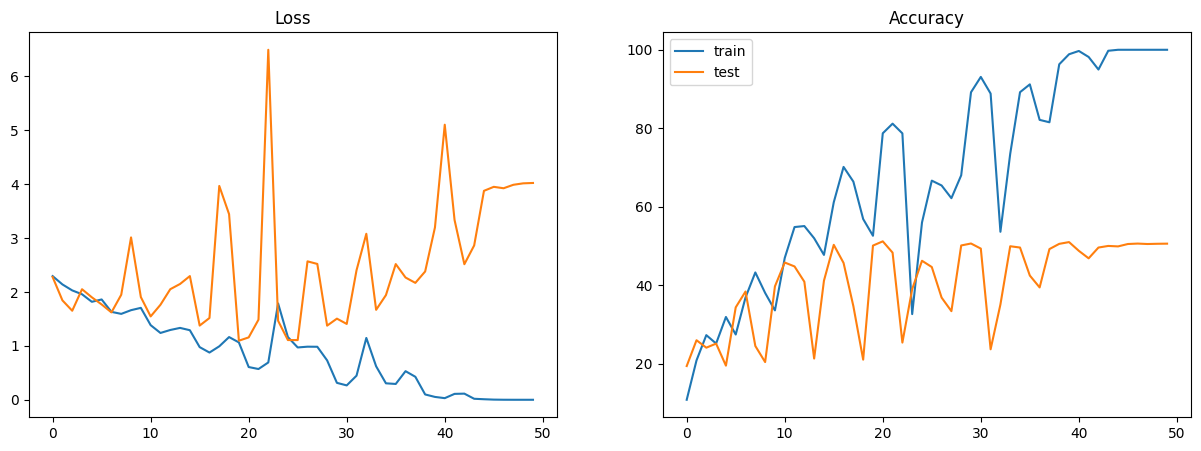

In [50]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_05, label="train")
ax1.plot(test_losses_05, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_05, label="train")
ax2.plot(test_accuracies_05, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_05.png")

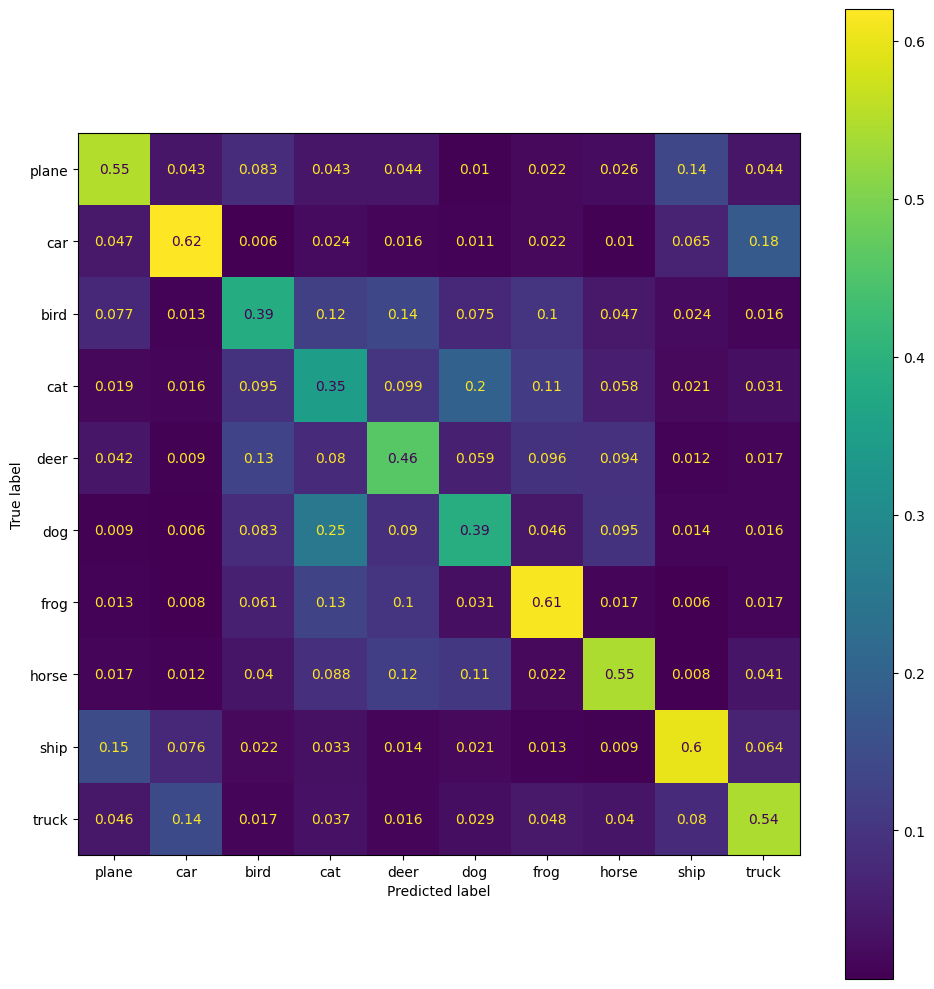

In [51]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_05(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_05.png")

Test Accuracy: 50.57%


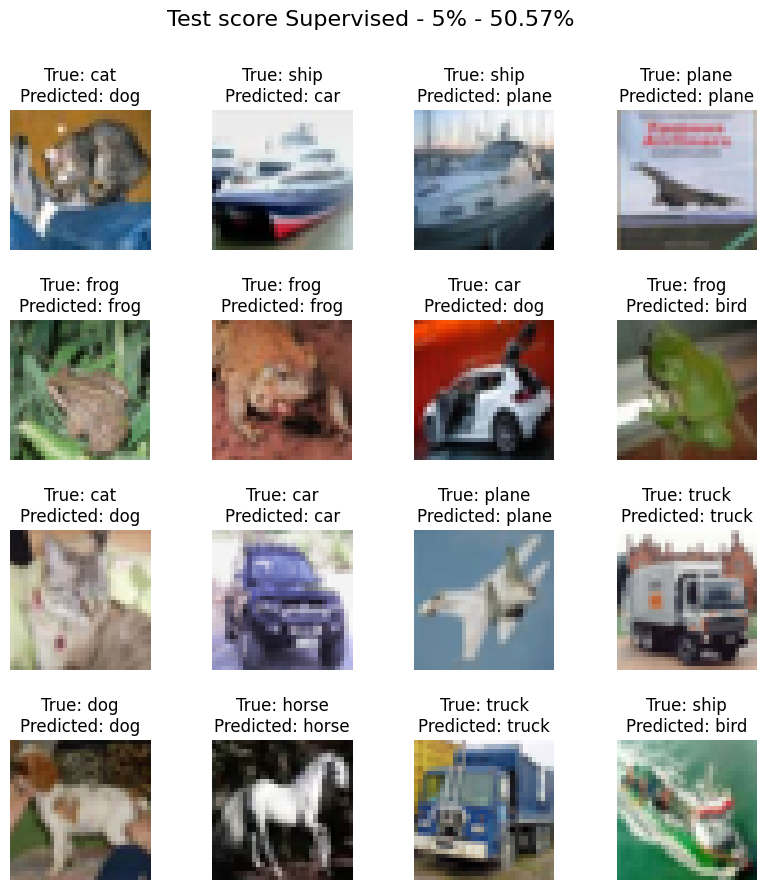

In [52]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_05(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score Supervised - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_10.png")

### II.4 CNN on 1% dataset

In [39]:
seedEverything()

SUBSET_PROP = 0.01

trainset_subsample, _ = torch.utils.data.random_split(trainset, [SUBSET_PROP, 1-SUBSET_PROP])

trainloader_subsample = DataLoader(
    trainset_subsample,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

In [40]:
EPOCHS = 50

# model
model = ConvNN().to(device)

# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define the learning rate scheduler
lr_lambda = lambda step: LR * 0.5 * (1 + torch.cos(torch.tensor((7 * torch.pi * (step-1)) / (16 * len(trainloader_subsample))))) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [41]:
supervised_train(
    model=model,
    trainloader=trainloader_subsample,
    testloader=testloader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    mean=mean,
    std=std,
    epochs=EPOCHS,
    name='01'
)

Start training


Epoch     0:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 9.99%


Epoch     1:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.07%


Epoch     2:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.06%


Epoch     3:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 9.99%


Epoch     4:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 9.97%


Epoch     5:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.01%


Epoch     6:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.0%


Epoch     7:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.02%


Epoch     8:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.07%


Epoch     9:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.22%


Epoch    10:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.31%


Epoch    11:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.34%


Epoch    12:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.39%


Epoch    13:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.52%


Epoch    14:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.64%


Epoch    15:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.7%


Epoch    16:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.72%


Epoch    17:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.68%


Epoch    18:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.9%


Epoch    19:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 10.98%


Epoch    20:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.09%


Epoch    21:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.08%


Epoch    22:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.18%


Epoch    23:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.24%


Epoch    24:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.3%


Epoch    25:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.32%


Epoch    26:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.28%


Epoch    27:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.41%


Epoch    28:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.43%


Epoch    29:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.44%


Epoch    30:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.48%


Epoch    31:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.5%


Epoch    32:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.48%


Epoch    33:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.49%


Epoch    34:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.5%


Epoch    35:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.5%


Epoch    36:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.53%


Epoch    37:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.63%


Epoch    38:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.51%


Epoch    39:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.49%


Epoch    40:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.56%


Epoch    41:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.55%


Epoch    42:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.54%


Epoch    43:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.55%


Epoch    44:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.6%


Epoch    45:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.62%


Epoch    46:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.54%


Epoch    47:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.58%


Epoch    48:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.56%


Epoch    49:   0%|          | 0/8 [00:00<?, ?batch/s]

Test Accuracy: 11.61%
Finished Training


In [42]:
# open results
model_01 = ConvNN().to(device)
model_01.load_state_dict(torch.load('./results/models/model_01.pth'))
train_losses_01 = torch.load('./results/metrics/train_losses_01.pth')
train_accuracies_01 = torch.load('./results/metrics/train_accuracies_01.pth')
test_losses_01 = torch.load('./results/metrics/test_losses_01.pth')
test_accuracies_01 = torch.load('./results/metrics/test_accuracies_01.pth')

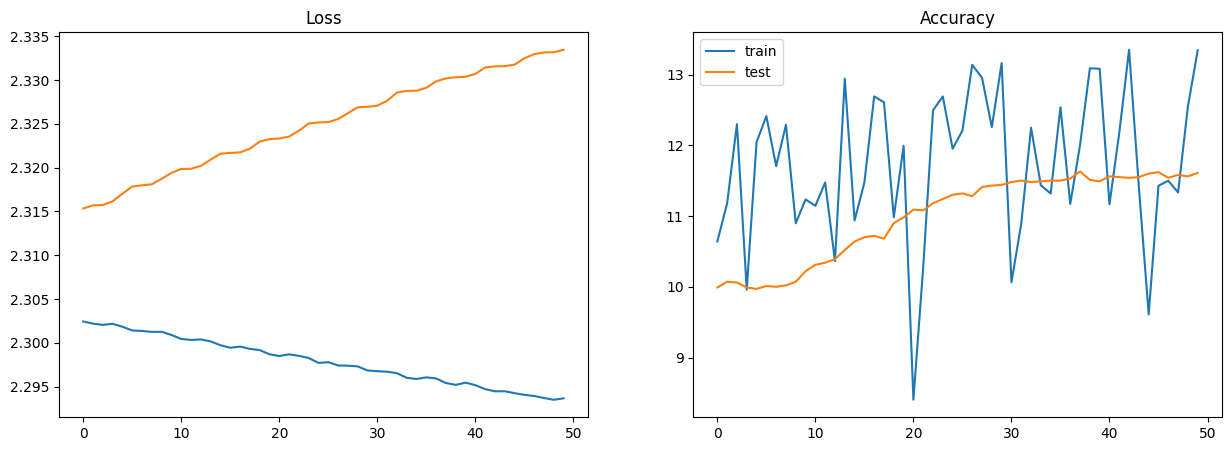

In [43]:
# plot losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses_01, label="train")
ax1.plot(test_losses_01, label="test")
ax1.set_title("Loss")

ax2.plot(train_accuracies_01, label="train")
ax2.plot(test_accuracies_01, label="test")
ax2.set_title("Accuracy")

plt.legend()
plt.show()

# save plot
fig.savefig(f"./results/figures/losses_accuracies_01.png")

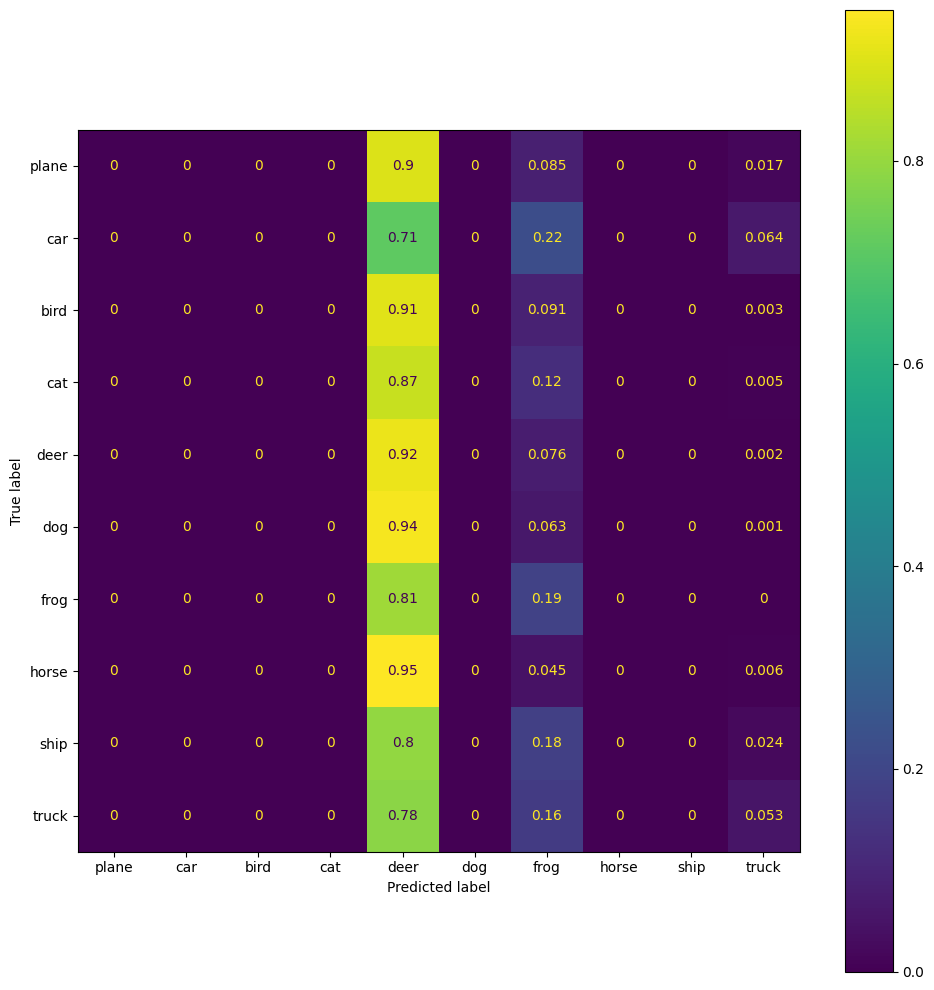

In [44]:
# plot confusion matrix
model.eval()  # Set the model to evaluation mode
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # normalize
        images = normalize(mean, std)(images)
        
        outputs = model_01(images)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax)
    plt.tight_layout()
    plt.show()

    # save plot
    fig.savefig(f"./results/figures/confusion_matrix_01.png")

Test Accuracy: 11.61%


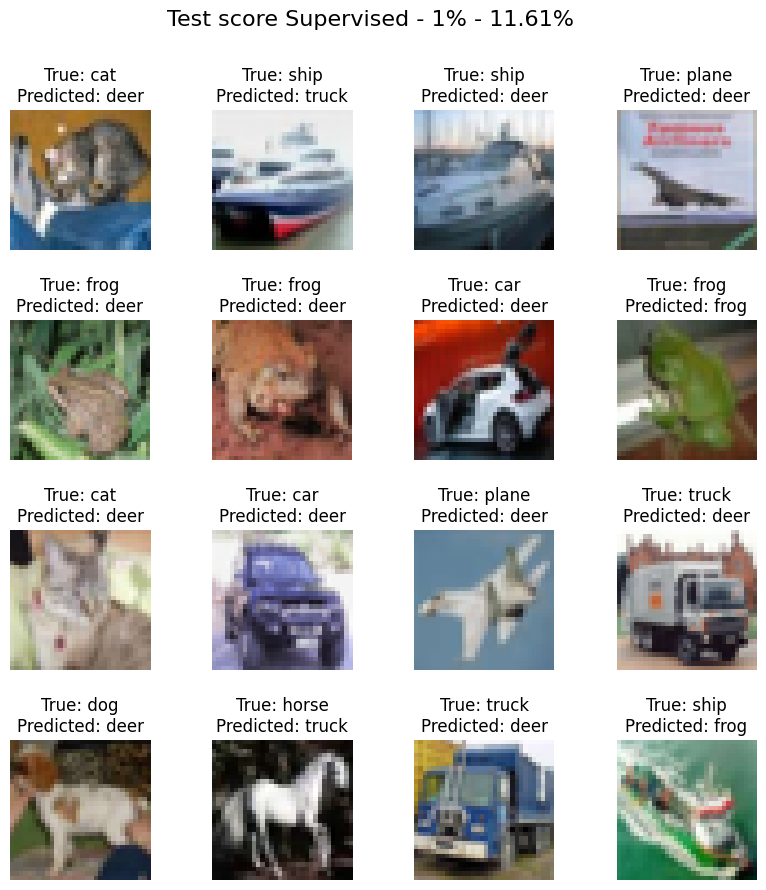

In [45]:
# Evaluation on the test set
test_accuracy = 100.0 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')

test_image, test_labels = testloader.__iter__().__next__()
test_image = test_image.to(device)
test_image_norm = normalize(mean, std)(test_image)
outputs_test = model_01(test_image_norm)
label_pred_test = outputs_test.argmax(dim=1)

fig1 = plot_images(test_image, test_labels, label_pred_test, classes, figure_name=f"Test score Supervised - {int(SUBSET_PROP*100)}% - {test_accuracy:.2f}%")
fig1.savefig(f"./results/figures/test_score_01.png")